<a href="https://colab.research.google.com/github/reiinakano/neural-painters/blob/master/notebooks/visualizing_imagenet_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [0]:
!pip install ipdb tqdm cloudpickle matplotlib lucid PyDrive

## Download checkpoint files for painters

In [0]:
!mkdir tf_vae
!wget -O tf_vae/vae-300000.index 'https://docs.google.com/uc?export=download&id=1ulHdDxebH46m_0ZoLa2Wsz_6vStYqJQm'
!wget -O tf_vae/vae-300000.meta 'https://docs.google.com/uc?export=download&id=1nHN_i7Ro9g0lP4y_YQCvIWrOVX1I3CJa'
!wget -O tf_vae/vae-300000.data-00000-of-00001 'https://docs.google.com/uc?export=download&id=18rAJcUJwFJOAcjzsabtqK12udsHMZkVk'
!wget -O tf_vae/checkpoint 'https://docs.google.com/uc?export=download&id=18U4qMNBdyvEk-Y-Mr3MNPEHSHxhcO9hn'

!mkdir tf_gan3
!wget -O tf_gan3/gan-571445.meta 'https://docs.google.com/uc?export=download&id=15kEG1Tiu2FUg5SILVt_9yOsSd3QHwVGA'
!wget -O tf_gan3/gan-571445.index 'https://docs.google.com/uc?export=download&id=11uyFbQsRZoWa9Yq52AFXDXPjPQoGF_ER'
!wget -O tf_gan3/gan-571445.data-00000-of-00001 'https://docs.google.com/uc?export=download&id=11cbvz-CH3KvfZEwNQ2OUujfbf6AKNoQa'
!wget -O tf_gan3/checkpoint 'https://docs.google.com/uc?export=download&id=1A539u51t0L31Ab1M2uPUV2SsCFsNDQRo'

!mkdir tf_gan4
!wget -O tf_gan4/gan-279892.meta 'https://docs.google.com/uc?export=download&id=15qcjIqxnJ7UaB_EP8Jko1IjpY1JQMCh7'
!wget -O tf_gan4/gan-279892.index 'https://docs.google.com/uc?export=download&id=1q5g-q04HOGpNJY83tk4_0aRLwg800av1'
!wget -O tf_gan4/gan-279892.data-00000-of-00001 'https://docs.google.com/uc?export=download&id=1Jtx9_5Dms9NXUnNq8r-TIf94dZyDjdBj'
!wget -O tf_gan4/checkpoint 'https://docs.google.com/uc?export=download&id=1cnagxjLZvWWWPFl0FJzTVuoja2HorBk8'


## Imports

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as tcl

from IPython.display import display
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.redirected_relu_grad import redirected_relu_grad, redirected_relu6_grad
from lucid.misc.gradient_override import gradient_override_map

print(tf.__version__)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4169728/45929032 bytes (9.1%)8241152/45929032 bytes (17.9%)12378112/45929032 bytes (27.0%)16400384/45929032 bytes (35.7%)20529152/45929032 bytes (44.7%)24657920/45929032 bytes (53.7%)28778496/45929032 bytes (62.7%)32292864/45929032 bytes (70.3%)36364288/45929032 bytes (79.2%)40517632/45929032 bytes (88.2%)44605440/45929032 bytes (97.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

## VAE painter

In [0]:
class ConvVAE2(object):
  def __init__(self, reuse=False, gpu_mode=True, graph=None):
    self.z_size = 64
    self.reuse = reuse
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('conv_vae using cpu.')
        self._build_graph(graph)
    else:
      tf.logging.info('conv_vae using gpu.')
      self._build_graph(graph)
    self._init_session()
  
  def build_decoder(self, z, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
      h = tf.layers.dense(z, 4*256, name="fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="deconv1")
      h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="deconv2")
      h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="deconv3")
      return tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="deconv4")
  
  def build_predictor(self, actions, reuse=False, is_training=False):
    with tf.variable_scope('predictor', reuse=reuse):
      h = tf.layers.dense(actions, 256, activation=tf.nn.leaky_relu, name="fc1")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn1")
      h = tf.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc2")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn2")
      h = tf.layers.dense(h, 64, activation=tf.nn.leaky_relu, name="fc3")
      h = tf.layers.batch_normalization(h, training=is_training, name="bn3")
      return tf.layers.dense(h, self.z_size, name='fc4')
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    with self.g.as_default(), tf.variable_scope('conv_vae', reuse=self.reuse):
      
      #### predicting part
      self.actions = tf.placeholder(tf.float32, shape=[None, 12])
      self.predicted_z = self.build_predictor(self.actions, is_training=False)
      self.predicted_y = self.build_decoder(self.predicted_z)
      
      # initialize vars
      self.init = tf.global_variables_initializer()
  
  def generate_stroke_graph(self, actions):
    with tf.variable_scope('conv_vae', reuse=True):
      with self.g.as_default():
        # Encoder?
        z = self.build_predictor(actions, reuse=True, is_training=False)

        # Decoder
        return self.build_decoder(z, reuse=True)

  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()


## GAN Painter

In [0]:
def relu_batch_norm(x):
    return tf.nn.relu(tf.contrib.layers.batch_norm(x, updates_collections=None))

class GeneratorConditional(object):
    def __init__(self, divisor=1, add_noise=False):
        self.x_dim = 64 * 64 * 3
        self.divisor=divisor
        self.name = 'lsun/dcgan/g_net'
        self.add_noise = add_noise

    def __call__(self, conditions, is_training):
        with tf.contrib.framework.arg_scope([tcl.batch_norm], 
                                            is_training=is_training):
          with tf.variable_scope(self.name) as vs:
              bs = tf.shape(conditions)[0]
              if self.add_noise:
                conditions = tf.concat([conditions, tf.random.uniform([bs, 10])], axis=1)
              fc = tcl.fully_connected(conditions, 4 * 4 * 1024/self.divisor, activation_fn=tf.identity)
              conv1 = tf.reshape(fc, tf.stack([bs, 4, 4, 1024/self.divisor]))
              conv1 = relu_batch_norm(conv1)
              conv2 = tcl.conv2d_transpose(
                  conv1, 512/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv3 = tcl.conv2d_transpose(
                  conv2, 256/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv4 = tcl.conv2d_transpose(
                  conv3, 128/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv5 = tcl.conv2d_transpose(
                  conv4, 3, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=tf.sigmoid)
              return conv5

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

In [0]:
class ConvGAN(object):
  def __init__(self, add_noise=False, reuse=False, gpu_mode=True, graph=None):
    self.reuse = reuse
    self.g_net = GeneratorConditional(divisor=4, add_noise=add_noise)
    
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('conv_gan using cpu.')
        self._build_graph(graph)
    else:
      tf.logging.info('conv_gan using gpu.')
      self._build_graph(graph)
    self._init_session()
      
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
      
    with self.g.as_default(), tf.variable_scope('conv_gan', reuse=self.reuse):
      self.actions = tf.placeholder(tf.float32, shape=[None, 12])
      self.y = self.g_net(self.actions, is_training=False)
      self.init = tf.global_variables_initializer()
  
  def generate_stroke_graph(self, actions):
    with tf.variable_scope('conv_gan', reuse=True):
      with self.g.as_default():
        return self.g_net(actions, is_training=False)
      
  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()


## Construct the Lucid graph

In [0]:
def import_model(model, t_image, t_image_raw, scope="import"):

  model.import_graph(t_image, scope=scope, forget_xy_shape=True)

  def T(layer):
    if layer == "input": return t_image_raw
    if layer == "labels": return model.labels
    if ":" in layer:
        return t_image.graph.get_tensor_by_name("%s/%s" % (scope,layer))
    else:
        return t_image.graph.get_tensor_by_name("%s/%s:0" % (scope,layer))

  return T

class LucidGraph(object):
  def __init__(self, class_to_plot='centipede', num_strokes=15, batch_size=1, painter_type="GAN", 
               connected=True, add_noise=False, lr=0.05, models_to_optimize=['inception_v1', 'inception_v1_slim'], gpu_mode=True, graph=None):
    self.num_strokes= num_strokes
    self.class_to_plot = class_to_plot
    self.batch_size = batch_size
    self.painter_type = painter_type
    self.connected=connected
    self.add_noise = add_noise
    
    self.inception_v1 = models.InceptionV1()
    self.inception_v1.load_graphdef()
    
    self.inception_v1_slim = models.InceptionV1_slim()
    self.inception_v1_slim.load_graphdef()
    
    self.inception_v2_slim = models.InceptionV2_slim()
    self.inception_v2_slim.load_graphdef()
    
    self.mobilenet_v2_14 = models.MobilenetV2_14_slim()
    self.mobilenet_v2_14.load_graphdef()
    
    self.resnet_v1_50 = models.ResnetV1_50_slim()
    self.resnet_v1_50.load_graphdef()
    
    transforms = [
      #transform.pad(12, mode='constant', constant_value=.5),
      transform.jitter(8),
      #transform.random_scale([1 + (i-5)/50. for i in range(11)]),
      transform.random_rotate(list(range(-20, 21)) + 5*[0]),
      transform.jitter(4),
    ]
    
    self.transform_f = render.make_transform_f(transforms)
    
    self.optim = render.make_optimizer(tf.train.AdamOptimizer(lr), [])
    
    self.obj_inception_v1 = objectives.class_logit('softmax1', class_to_plot)
    self.obj_inception_v1_slim = objectives.class_logit('InceptionV1/Logits/Predictions/Softmax', class_to_plot)
    self.obj_inception_v2_slim = objectives.class_logit('InceptionV2/Predictions/Softmax', class_to_plot)
    self.obj_mobilenet_v2_14 = objectives.class_logit('MobilenetV2/Predictions/Softmax', class_to_plot)
    self.obj_resnet_v1_50 = objectives.class_logit('resnet_v1_50/predictions/Softmax', class_to_plot)
    
    self.models_to_optimize_dict = {
        'inception_v1': {'model': self.inception_v1, 'obj': self.obj_inception_v1, 'scope': 'i'},
        'inception_v1_slim': {'model': self.inception_v1_slim, 'obj': self.obj_inception_v1_slim, 'scope': 'i_slim'},
        'inception_v2_slim': {'model': self.inception_v2_slim, 'obj': self.obj_inception_v2_slim, 'scope': 'i2_slim'},
        'mobilenet_v2_14': {'model': self.mobilenet_v2_14, 'obj': self.obj_mobilenet_v2_14, 'scope': 'm_v2_14'},
        'resnet_v1_50': {'model': self.resnet_v1_50, 'obj': self.obj_resnet_v1_50, 'scope': 'resnet_v1_50'}
    }
    
    self.models_to_optimize = [self.models_to_optimize_dict[key] for key in models_to_optimize]

    self.gpu_mode = gpu_mode
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('Model using cpu.')
        self._build_graph(graph)
    else:
      #tf.logging.info('Model using gpu.')
      self._build_graph(graph)
    self._init_session()
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    
    # Set up graphs of VAE or GAN
    if self.painter_type == "GAN":
      self.painter = ConvGAN(
              add_noise=self.add_noise,
              reuse=False,
              gpu_mode=self.gpu_mode,
              graph=self.g)
    elif self.painter_type=="VAE":
      self.painter = ConvVAE2(
              reuse=False,
              gpu_mode=self.gpu_mode,
              graph=self.g)
    self.painter.close_sess()
    
    with self.g.as_default():
      print('GLOBAL VARS', tf.global_variables())
    
    with self.g.as_default():
      batch_size = self.batch_size
      tile_size = 5
      self.actions = tf.get_variable("action_vars", [batch_size, self.num_strokes, 12], 
                                     #initializer=tf.initializers.random_normal()
                                     initializer=tf.initializers.random_uniform()
                                    )
      
      # Prepare loop vars for rnn loop
      canvas_state = tf.ones(shape=[batch_size, 64, 64, 3], dtype=tf.float32)
      i = tf.constant(0)
      initial_canvas_ta = tf.TensorArray(dtype=tf.float32, size=self.num_strokes)
      loop_vars = (
          canvas_state, 
          initial_canvas_ta, i)
      
      
      # condition for continuation
      def cond(cs, c_ta, i):
        return tf.less(i, self.num_strokes)
      
      # run one state of rnn cell
      def body(cs, c_ta, i):
        
        trimmed_actions = tf.sigmoid(self.actions)
        
        print(trimmed_actions.get_shape())
        
        def use_whole_action():
          return trimmed_actions[:, i, :12]
        
        def use_previous_entrypoint():
          # start x and y are previous end x and y
          # start pressure is previous pressure
          return tf.concat([trimmed_actions[:, i, :9], trimmed_actions[:, i-1, 4:6], trimmed_actions[:, i-1, 0:1]], axis=1)
        
        if self.connected:
          inp = tf.cond(tf.equal(i, 0), true_fn=use_whole_action, false_fn=use_previous_entrypoint)
        else:
          inp = use_whole_action()
        inp = tf.reshape(inp, [-1, 12])
        
        print(inp.get_shape())
        
        decoded_stroke = self.painter.generate_stroke_graph(inp)

        darkness_mask = tf.reduce_mean(decoded_stroke, axis=3)
        darkness_mask = 1 - tf.reshape(darkness_mask, [batch_size, 64, 64, 1])
        darkness_mask = darkness_mask / tf.reduce_max(darkness_mask)
        
        color_action = trimmed_actions[:, i, 6:9]
        color_action = tf.reshape(color_action, [batch_size, 1, 1, 3])
        color_action = tf.tile(color_action, [1, 64, 64, 1])
        stroke_whitespace = tf.equal(decoded_stroke, 1.)
        maxed_stroke = tf.where(stroke_whitespace, decoded_stroke, color_action)
        
        cs = (darkness_mask)*maxed_stroke + (1-darkness_mask)*cs
        c_ta = c_ta.write(i-1, cs)
                
        i = tf.add(i, 1)
        return (cs, c_ta, i)
      
      final_canvas_state, final_canvas_ta, _ = tf.while_loop(cond, body, loop_vars, swap_memory=True)
      self.final_canvas_state = final_canvas_state
      self.intermediate_canvases = final_canvas_ta.stack()
      
      self.resized_canvas = tf.image.resize_images(self.final_canvas_state, [224, 224])
      self.resized_canvas_227 = tf.image.resize_images(self.final_canvas_state, [227, 227])
      tiled_canvas = tf.tile(self.resized_canvas, [tile_size, 1, 1, 1])
      tiled_canvas_227 = tf.tile(self.resized_canvas_227, [tile_size, 1, 1, 1])
      
      global_step = tf.train.get_or_create_global_step()
      
      with gradient_override_map({'Relu': redirected_relu_grad,
                                  'Relu6': redirected_relu6_grad}):
        #self.T = render.import_model(self.inception_v1, self.transform_f(tiled_canvas), tiled_canvas)
        #self.T2 = import_model(self.inception_v1_slim, self.transform_f(tiled_canvas), tiled_canvas, scope='i_slim')
        #self.T3 = import_model(self.inception_v2_slim, self.transform_f(tiled_canvas), tiled_canvas, scope='i2_slim')
        T_list = [import_model(x['model'], self.transform_f(tiled_canvas), tiled_canvas, scope=x['scope']) 
                  for x in self.models_to_optimize]
          
          
      self.loss = 0
      self.loss_list = []
      for i in range(len(T_list)):
        l = self.models_to_optimize[i]['obj'](T_list[i])/tile_size
        self.loss = self.loss + l
        self.loss_list.append(l)
      self.loss = self.loss / len(T_list)
        
      #self.loss = self.obj_inception_v1(self.T)/5 + self.obj_inception_v1_slim(self.T2)/5 + self.obj_inception_v2_slim(self.T3)/5
      
      self.vis_op = self.optim.minimize(-self.loss, global_step=global_step, var_list=[self.actions])

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      print('TRAINABLE', tf.trainable_variables())
      
  def train(self, thresholds=range(0, 5000, 30)):
    self.images = []
    vis = self.sess.run(self.resized_canvas)
    show(np.hstack(vis))
    try:
      for i in range(max(thresholds)+1):
        loss_, _ = self.sess.run([self.loss_list, self.vis_op])
        if i in thresholds:
          #print(self.sess.run(self.actions))
          vis = self.sess.run(self.resized_canvas)
          print('step', i, 'scores_per_net', loss_, 'max_score', self.batch_size)
          show(np.hstack(vis))
        if i % 1 == 0:
          vis = self.sess.run(self.resized_canvas)
          self.images.append(vis)
    except KeyboardInterrupt:
      vis = self.sess.run(self.resized_canvas)
      show(np.hstack(vis))

  def _init_session(self):
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    self.sess.close()
    
      
  def load_painter_checkpoint(self, checkpoint_path='tf_conv_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      if self.painter_type == "VAE":
        pth = 'conv_vae'
      elif self.painter_type == "GAN":
        pth = 'conv_gan'
      saver = tf.train.Saver(tf.global_variables(pth))
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)


## Utility code for searching available ImageNet classes

You don't really need this but I found it helpful to look for classes to optimize. 

You will notice that the labels for the Slim models are not always the same as the labels for inception_v1 for the same object e.g. 'lipstick' vs 'lipstick, lip rouge'. In this case, you can't optimize inception_v1 together with a Slim model (of course, you are free to use inception_v1_slim).

In [8]:
def search(_search_term):
  print('searching matching labels for {}'.format(_search_term))
  inception_v1 = models.InceptionV1()
  inception_v1_slim = models.InceptionV1_slim()
  inception_v2_slim = models.InceptionV2_slim()
  mobilenet_v2_14 = models.MobilenetV2_14_slim()
  resnet_v1_50 = models.ResnetV1_50_slim()

  print('inception_v1 labels: {}'.format([x for x in inception_v1.labels if _search_term in x]))
  print('inception_v1_slim labels: {}'.format([x for x in inception_v1_slim.labels if _search_term in x]))
  print('inception_v2_slim labels: {}'.format([x for x in inception_v2_slim.labels if _search_term in x]))
  print('mobilenet_v2_14 labels: {}'.format([x for x in mobilenet_v2_14.labels if _search_term in x]))
  print('resnet_v1_50 labels: {}'.format([x for x in resnet_v1_50.labels if _search_term in x]))
  
search('l')

searching matching labels for l
inception_v1 labels: [u'English setter', u'Australian terrier', u'English springer', u'grey whale', u'lesser panda', u'gazelle', u'sea lion', u'malamute', u'Walker hound', u'Welsh springer spaniel', u'killer whale', u'African elephant', u'red wolf', u'Old English sheepdog', u'bloodhound', u'Airedale', u'three-toed sloth', u'sorrel', u'black-footed ferret', u'dalmatian', u'black-and-tan coonhound', u'papillon', u'Staffordshire bullterrier', u'Mexican hairless', u'Bouvier des Flandres', u'weasel', u'miniature poodle', u'malinois', u'fox squirrel', u'colobus', u'impala', u'Newfoundland', u'Norwegian elkhound', u'Rottweiler', u'Saluki', u'West Highland white terrier', u'Sealyham terrier', u'Irish wolfhound', u'wild boar', u'EntleBucher', u'French bulldog', u'leopard', u'Maltese dog', u'Norfolk terrier', u'vizsla', u'squirrel monkey', u'groenendael', u'clumber', u'Japanese spaniel', u'white wolf', u'gorilla', u'toy poodle', u'Kerry blue terrier', u'Boston bul

## Choose parameters

In [9]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto", display-mode: "form" }

CATEGORY_TO_OPTIMIZE = "honeycomb" #@param {type:"string"}
#@markdown Some of my favorite categories are "bee", "lemon", "strawberry", "Granny Smith", "pelican" (pelican is quite difficult to optimize)
NUMBER_STROKES = 30 #@param {type:"slider", min:1, max:100, step:1}
BATCH_SIZE = 3 #@param {type:"slider", min:1, max:5, step:1}
PAINTER_MODE = "VAE" #@param ["GAN", "VAE"]
#@markdown VAE mode results in more solid strokes that are easier to optimize for.
#@markdown GAN mode results in strokes that actually look like paintbrush strokes, although they might be harder to optimize for.
ADD_NOISE = False #@param {type:"boolean"}
#@markdown Experimental. Adding uncertainty may (or may not) help produce more robust images. Currently only the GAN painter uses this parameter.
CONNECTED_STROKES = False #@param {type:"boolean"}
#@markdown If true, strokes begin at the endpoint of the previous stroke. Otherwise, strokes are independent and can start anywhere.
LEARNING_RATE = 0.05 #@param {type: "number"}

#@markdown ---
#@markdown ### Choose which models are optimized *at the same time*:
USE_INCEPTION_V1 = False #@param {type:"boolean"}
USE_INCEPTION_V1_SLIM = True #@param {type:"boolean"}
USE_INCEPTION_V2_SLIM = True #@param {type:"boolean"}
USE_MOBILENET_V2_14 = True #@param {type:"boolean"}
USE_RESNET_V1_50 = True #@param {type:"boolean"}

MODELS_TO_OPTIMIZE = []
if USE_INCEPTION_V1:
  MODELS_TO_OPTIMIZE.append('inception_v1')
if USE_INCEPTION_V1_SLIM:
  MODELS_TO_OPTIMIZE.append('inception_v1_slim')
if USE_INCEPTION_V2_SLIM:
  MODELS_TO_OPTIMIZE.append('inception_v2_slim')
if USE_MOBILENET_V2_14:
  MODELS_TO_OPTIMIZE.append('mobilenet_v2_14')
if USE_RESNET_V1_50:
  MODELS_TO_OPTIMIZE.append('resnet_v1_50')

print("Category to optimize", CATEGORY_TO_OPTIMIZE)
print("Number of strokes", NUMBER_STROKES)
print("Batch size", BATCH_SIZE)
print("Using {} painter".format(PAINTER_MODE))
print("Adding noise", ADD_NOISE)
print("Using connected strokes", CONNECTED_STROKES)
print("Learning Rate", LEARNING_RATE)
print("Models to optimize", MODELS_TO_OPTIMIZE)
print('--------------------')
search(CATEGORY_TO_OPTIMIZE)

if USE_INCEPTION_V1:
  if CATEGORY_TO_OPTIMIZE not in models.InceptionV1().labels:
    raise Exception("{} not in inception_v1".format(CATEGORY_TO_OPTIMIZE))
if USE_INCEPTION_V1_SLIM:
  if CATEGORY_TO_OPTIMIZE not in models.InceptionV1_slim().labels:
    raise Exception("{} not in inception_v1_slim".format(CATEGORY_TO_OPTIMIZE))
if USE_INCEPTION_V2_SLIM:
  if CATEGORY_TO_OPTIMIZE not in models.InceptionV2_slim().labels:
    raise Exception("{} not in inception_v2_slim".format(CATEGORY_TO_OPTIMIZE))
if USE_MOBILENET_V2_14:
  if CATEGORY_TO_OPTIMIZE not in models.MobilenetV2_14_slim().labels:
    raise Exception("{} not in mobilenet_v2_14".format(CATEGORY_TO_OPTIMIZE))
if USE_RESNET_V1_50:
  if CATEGORY_TO_OPTIMIZE not in models.ResnetV1_50_slim().labels:
    raise Exception("{} not in resnet_v1_50".format(CATEGORY_TO_OPTIMIZE))


('Category to optimize', 'honeycomb')
('Number of strokes', 30)
('Batch size', 3)
Using VAE painter
('Adding noise', False)
('Using connected strokes', False)
('Learning Rate', 0.05)
('Models to optimize', ['inception_v1_slim', 'inception_v2_slim', 'mobilenet_v2_14', 'resnet_v1_50'])
--------------------
searching matching labels for honeycomb
inception_v1 labels: [u'honeycomb']
inception_v1_slim labels: [u'honeycomb']
inception_v2_slim labels: [u'honeycomb']
mobilenet_v2_14 labels: [u'honeycomb']
resnet_v1_50 labels: [u'honeycomb']


## Run!

In [0]:
lol = LucidGraph(CATEGORY_TO_OPTIMIZE, NUMBER_STROKES, BATCH_SIZE, 
                 painter_type=PAINTER_MODE, connected=CONNECTED_STROKES, 
                 add_noise=ADD_NOISE, lr=LEARNING_RATE,
                 models_to_optimize=MODELS_TO_OPTIMIZE)
if PAINTER_MODE == "GAN":
  if ADD_NOISE:
    lol.load_painter_checkpoint('tf_gan4')
  else:
    lol.load_painter_checkpoint('tf_gan3')
elif PAINTER_MODE == "VAE":
  lol.load_painter_checkpoint('tf_vae')
lol.train()

## Evaluate results


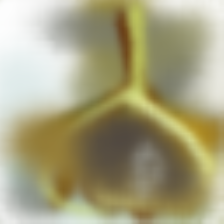


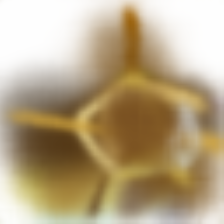


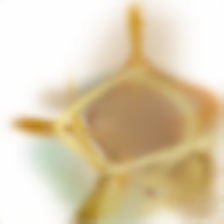

In [11]:
def print_results():
  def sigmoid(x):
      s = 1/(1+np.exp(-x))
      return s

  acs, dream_paintings = lol.sess.run([lol.actions, lol.resized_canvas])
  actual_acs = sigmoid(acs)
  for p in dream_paintings:
    show(p)

print_results()

In [12]:
def vid(my_frames):
  
  def frame(t):
    t = int(t*30)
    if t >= len(my_frames):
      t = len(my_frames)-1
    return (np.hstack(my_frames[t])*255).astype(np.float)

  clip = mpy.VideoClip(frame, duration=len(my_frames)/30.)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=200, max_duration=70.))
  
# If the video is too long, you can skip some
keep_1_in_n = 1
vid(lol.images[::keep_1_in_n])

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 412/413 [00:03<00:00, 135.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

